# Capstone project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>
Determining the best neighborhoods to open a restaurant in Toronto. This would be where restaurants are not concentrated. The solution to this problem would help investors interested in opening restaurants to decide where their business could thrive the most

## Data<a name="data"></a>
Based on definition of our problem, factors that will influence our decision are:
* Neighborhoods in Toronto
* number of existing restaurants in the neighborhood 
* location existing restaurants in the neighborhood 


Following data sources will be needed to extract/generate the required information:
* neighborhoods in Toronto:  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M,
* coordinates of neighborhoods in Toronto: http://cocl.us/Geospatial_data
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**


In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')


### Scraping neighborhoods in Canada

In [71]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

In [72]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Cleaning the data

In [73]:
# Get names of indexes for which column Borough is not assigned
indexNames = df[ df['Borough'] == "Not assigned" ].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
#Reset index
df.reset_index(drop=True, inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Loading the geospatial coordinates

In [74]:
Geo_data = pd.read_csv("Geospatial_Coordinates.csv")
Geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now, lets extract the coordinates and concatenate it with neighborhood data

In [75]:
postal_code=df["Postal Code"].to_list()
latitude = []
longitude = []
for pos in postal_code:
    lat=Geo_data[Geo_data["Postal Code"]==pos]["Latitude"].values
    long=Geo_data[Geo_data["Postal Code"]==pos]["Longitude"].values
    latitude.append(lat)
    longitude.append(long)

In [76]:
import numpy as np
df["Latitude"]= np.array(latitude)
df["Longitude"]= np.array(longitude)
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Focusing on Toronto 

In [77]:
Toronto_data = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
Toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


## Methodology <a name="methodology"></a>
The Kmeans clustering would be used to group the restaurants based on their closeness to each other. The numbers of resturants in each neighborhoods would then be determined

## Analysis <a name="analysis"></a>

Visualizing toronto and its neighborhoods

In [108]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [200]:
# create map of Toronto using latitude and longitude values
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
  
map_Toronto


### Four square API

we would now obtain the restaurants in Toronto using foursquare API

In [80]:
CLIENT_ID = 'EAICOJ12J3ACMNVMFYCRLORBSO4EJCHS12XYHY31GY05BYWM' 
CLIENT_SECRET = '2JJBT154RAEWHZ0LNTJEDS1V3OMQQ2QNXDMN5N3N5QNQYI5M' 
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EAICOJ12J3ACMNVMFYCRLORBSO4EJCHS12XYHY31GY05BYWM
CLIENT_SECRET:2JJBT154RAEWHZ0LNTJEDS1V3OMQQ2QNXDMN5N3N5QNQYI5M


In [98]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [99]:
#function that gets venues in a location within 500 mile radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now lets get the venues in Toronto and its neighborhoods

In [100]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [101]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1618, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [103]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


Now, we will focus on Restaurants in Toronto

In [106]:
Toronto_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
Toronto_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
1,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Flame Shack,43.656844,-79.358917,Restaurant
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Sushi Box,43.662960,-79.386580,Sushi Restaurant
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant


In [107]:
Toronto_restaurant.shape

(384, 7)

Let's view the Restaurants in the neighborhoods

In [151]:
# create map of Toronto using latitude and longitude values
import folium
map_Toronto_res = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_restaurant['Venue Latitude'], Toronto_restaurant['Venue Longitude'], Toronto_restaurant['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto_res)  
    
map_Toronto_res

### Clustering

Now we will cluster these restaurant based on their distance to each other, to this end , Kmeans clustering would be used

In [139]:
X=Toronto_restaurant.loc[:,['Venue Latitude','Venue Longitude']]

In [159]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [160]:
# add clustering labels
Toronto_restaurant['Cluster Labels'] = kmeans.labels_

let's visualize the clusters

In [162]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_restaurant['Venue Latitude'], Toronto_restaurant['Venue Longitude'], Toronto_restaurant['Venue Category'], Toronto_restaurant['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

Now, we can visualize the numbers of restaurants the neighborhoods in each clusters and decide that the best place to build a restaurant are where the number of existing restaurants are less than 5

#### First cluster

Text(0.5, 0, 'Number of restaurants')

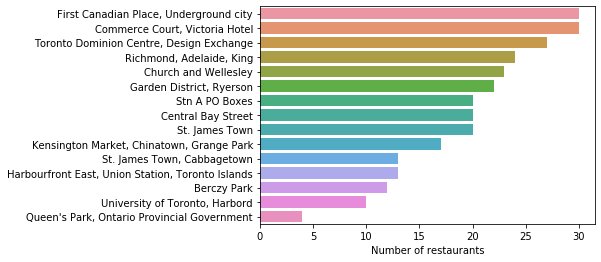

In [189]:
#Number of restaurants in each Neighborhood in cluster 0
import seaborn as sns
restaurant_count=Toronto_restaurant[Toronto_restaurant['Cluster Labels']==0]['Neighborhood'].value_counts()
X=restaurant_count.index
Y=restaurant_count.values
sns.barplot(Y,X)
plt.xlabel("Number of restaurants")

In this Cluster, there are many restaurants, a good neighborhood to build a restaurant would be Queen's Park, Ontario Provincial Government

#### Second cluster

Text(0.5, 0, 'Number of restaurants')

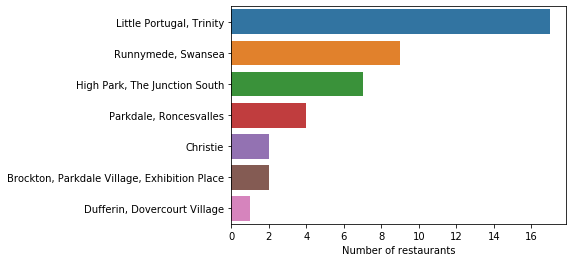

In [190]:
restaurant_count=Toronto_restaurant[Toronto_restaurant['Cluster Labels']==1]['Neighborhood'].value_counts()
X=restaurant_count.index
Y=restaurant_count.values
sns.barplot(Y,X)
plt.xlabel("Number of restaurants")

There isn't many restaurants in this cluster, the following are best neighborhoods to build a restaurant:

* Dufferin, Dovercourt Village
* Brockton, Parkdale Village, Exhibition Place
* Christie
* Parkdale, Roncesvalles

#### Third cluster

Text(0.5, 0, 'Number of restaurants')

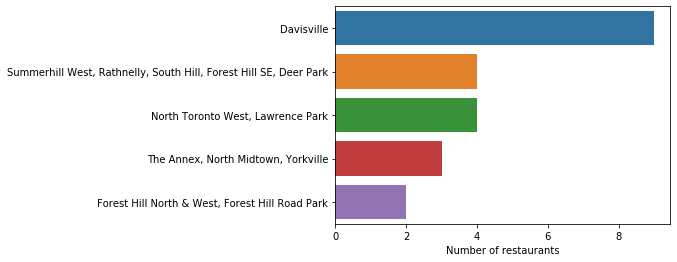

In [191]:
restaurant_count=Toronto_restaurant[Toronto_restaurant['Cluster Labels']==2]['Neighborhood'].value_counts()
X=restaurant_count.index
Y=restaurant_count.values
sns.barplot(Y,X)
plt.xlabel("Number of restaurants")

There isn't many restaurants in this cluster also, the following are best neighborhoods to build a restaurant:

* Forest Hill North & West, Forest Hill Road Park
* The Annex, North Midtown, Yorkville
* North Toronto West Lawrence Park
* Summerhill West

#### Forth Cluster

Text(0.5, 0, 'Number of restaurants')

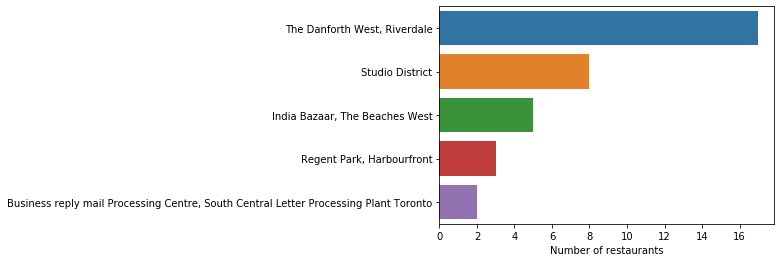

In [192]:
restaurant_count=Toronto_restaurant[Toronto_restaurant['Cluster Labels']==3]['Neighborhood'].value_counts()
X=restaurant_count.index
Y=restaurant_count.values
sns.barplot(Y,X)
plt.xlabel("Number of restaurants")

There isn't many restaurants in this cluster also, the following are best neighborhoods to build a restaurant:

* Business reply mail Processing Center
* Regent Park
* India Bazaar

## Conclusion <a name="conclusion"></a>

In conclusion, the restaurants in Toronto have been grouped into four clusters. There are quite a number of restaurants in the first cluster, hence it wont be wise to set up a new restaurant there. The remaining clusters have few restaurants and as a result would be good locations to set up a new restaurants.